<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week4_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 4: Decision Tree
### Prof. Charles Dorner, EdD (Candidate)
### College of Computing and Informatics, Drexel University

# Import packages

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import matplotlib
matplotlib.rcParams["font.family"] = "DejaVu Sans"   # or any font that exists

# Error Rate, Entropy, Gini Index
Measuring the uncertainty of an event with a probability

In [ ]:
# 0. Imports ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, warnings, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
warnings.filterwarnings("ignore")          # silence font + dtreeviz chatter

try:
    import dtreeviz
    HAVE_DTV = True
except ModuleNotFoundError:
    HAVE_DTV = False                     # will fallback gracefull

In [136]:
# — ENTROPY / GINI WALK‑THROUGH  +  ENCODING PREVIEWS —────────────────────
import math, numpy as np

# parent distribution 4‑4‑2  (10 samples)
entropy_442 = -((4/10)*math.log2(4/10) + (4/10)*math.log2(4/10) + (2/10)*math.log2(2/10))
gini_442    = 1 - ((4/10)**2 + (4/10)**2 + (2/10)**2)

# child A distribution 3‑2‑1  (6 samples)
entropy_321 = -((3/6)*math.log2(3/6) + (2/6)*math.log2(2/6) + (1/6)*math.log2(1/6))
gini_321    = 1 - ((3/6)**2 + (2/6)**2 + (1/6)**2)

# child B distribution 1‑2‑1  (4 samples)
entropy_121 = -((1/4)*math.log2(1/4) + (2/4)*math.log2(2/4) + (1/4)*math.log2(1/4))
gini_121    = 1 - ((1/4)**2 + (2/4)**2 + (1/4)**2)

# weighted subset impurity
entropy_subsets = (6/10)*entropy_321 + (4/10)*entropy_121
gini_subsets    = (6/10)*gini_321    + (4/10)*gini_121

info_gain_entropy = entropy_442 - entropy_subsets
info_gain_gini    = gini_442    - gini_subsets

print("entropy_442        =", round(entropy_442, 3))
print("entropy_321        =", round(entropy_321, 3))
print("entropy_121        =", round(entropy_121, 3))
print("info_gain_entropy  =", round(info_gain_entropy, 3), "\n")

print("gini_442           =", round(gini_442, 3))
print("gini_321           =", round(gini_321, 3))
print("gini_121           =", round(gini_121, 3))
print("info_gain_gini     =", round(info_gain_gini, 3), "\n")

# ───── Preview what actually feeds the tree ─────
print("Ordinal‑encoded features (first 5 rows):")
print(ord_dt.named_steps["enc"].transform(train[X_cols])[:5])

print("\nLabel‑encoded targets (train set):")
print(ord_dt['tree'].classes_)          # prints [0 1] → 'no' / 'yes'


entropy_442        = 1.522
entropy_321        = 1.459
entropy_121        = 1.5
info_gain_entropy  = 0.046 

gini_442           = 0.64
gini_321           = 0.611
gini_121           = 0.625
info_gain_gini     = 0.023 

Ordinal‑encoded features (first 5 rows):
[[0. 2. 1. 0.]
 [1. 1. 1. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [2. 0. 1. 1.]]

Label‑encoded targets (train set):
[0 1]


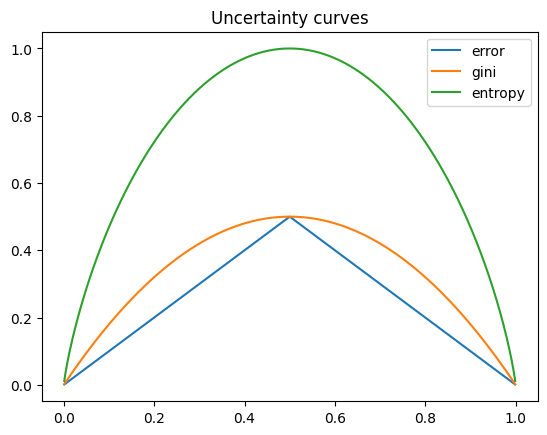

In [137]:
# 1. Uncertainty curves (error, gini, entropy) ─────────────────────────────
p = np.linspace(0.001, 0.999, 999)
plt.plot(p, 1-np.maximum(p,1-p), label="error")
plt.plot(p, 2*p*(1-p),           label="gini")
plt.plot(p, -(p*np.log2(p)+(1-p)*np.log2(1-p)), label="entropy")
plt.legend(); plt.title("Uncertainty curves"); plt.show()


In [138]:
# 2. Information‑gain demo --------------------------------------------------
parent = np.array([4,4,2]); childA = np.array([3,2,1]); childB = np.array([1,2,1])
H = lambda v: -(v/v.sum()*np.log2(v/v.sum(), where=v>0)).sum()
print("IG (entropy)", round(H(parent) - 0.6*H(childA) - 0.4*H(childB), 3))

IG (entropy) 0.046


In [139]:
# 3. Synthetic weather dataset ---------------------------------------------
rng = np.random.default_rng(42); N=50
weather = pd.DataFrame({
    "outlook":    rng.choice(["sunny","overcast","rainy"], N),
    "temperature":rng.choice(["hot","mild","cool"], N),
    "humidity":   rng.choice(["high","normal"], N),
    "windy":      rng.choice([False,True], N)
})
weather["play"] = np.where(
    (weather.outlook=="overcast") |
    ((weather.humidity=="normal") & (~weather.windy)), "yes","no")
print(weather.head(), "\nshape:", weather.shape)

train, test = train_test_split(weather, test_size=.2, stratify=weather.play,
                               random_state=0)
X_cols = ["outlook","temperature","humidity","windy"]
lab = LabelEncoder().fit(weather.play)
y_tr, y_te = lab.transform(train.play), lab.transform(test.play)

    outlook temperature humidity  windy play
0     sunny        cool   normal   True   no
1     rainy         hot     high  False   no
2  overcast        mild   normal   True  yes
3  overcast        mild     high  False  yes
4  overcast        mild   normal  False  yes 
shape: (50, 5)



Ordinal‑DT accuracy: 1.0   prec/rec/f1: (array([1., 1.]), array([1., 1.]), array([1., 1.]))
|--- outlook <= 0.50
|   |--- class: 1
|--- outlook >  0.50
|   |--- temperature <= 1.50
|   |   |--- humidity <= 0.50
|   |   |   |--- class: 0
|   |   |--- humidity >  0.50
|   |   |   |--- windy <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- windy >  0.50
|   |   |   |   |--- class: 0
|   |--- temperature >  1.50
|   |   |--- windy <= 0.50
|   |   |   |--- humidity <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- humidity >  0.50
|   |   |   |   |--- class: 1
|   |   |--- windy >  0.50
|   |   |   |--- class: 0



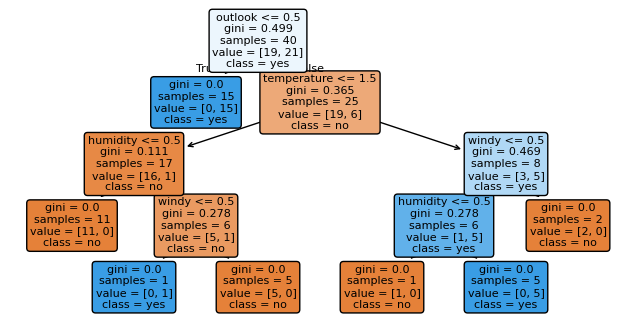

In [140]:
import logging
# Mute only the font‑manager logger
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

# If you want it totally gone:
# logging.getLogger("matplotlib.font_manager").disabled = True

# 4. Ordinal‑DT pipeline ----------------------------------------------------
ord_dt = Pipeline([
    ("enc", OrdinalEncoder()),
    ("tree", DecisionTreeClassifier(random_state=0))
]).fit(train[X_cols], y_tr)

y_pred = ord_dt.predict(test[X_cols])
print("\nOrdinal‑DT accuracy:", round(accuracy_score(y_te, y_pred),3),
      "  prec/rec/f1:", precision_recall_fscore_support(y_te, y_pred, zero_division=0)[0:3])

from sklearn import tree
print(tree.export_text(ord_dt.named_steps["tree"],
                       feature_names=ord_dt.named_steps["enc"].get_feature_names_out(X_cols)))

plt.figure(figsize=(8,4))
plot_tree(ord_dt.named_steps["tree"],
          feature_names=ord_dt.named_steps["enc"].get_feature_names_out(X_cols),
          class_names=lab.classes_, filled=True, rounded=True, fontsize=8); plt.show()

if HAVE_DTV:
    dtreeviz.model(ord_dt.named_steps["tree"],
                   ord_dt.named_steps["enc"].transform(train[X_cols]),
                   y_tr, feature_names=ord_dt.named_steps["enc"].get_feature_names_out(X_cols),
                   target_name="play", class_names=list(lab.classes_)).view(scale=1.2)


OneHot‑DT accuracy: 0.8   prec/rec/f1: (array([0.71428571, 1.        ]), array([1. , 0.6]), array([0.83333333, 0.75      ]))
|--- outlook_overcast <= 0.50
|   |--- temperature_mild <= 0.50
|   |   |--- humidity_high <= 0.50
|   |   |   |--- temperature_cool <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- temperature_cool >  0.50
|   |   |   |   |--- class: 0
|   |   |--- humidity_high >  0.50
|   |   |   |--- class: 0
|   |--- temperature_mild >  0.50
|   |   |--- windy_False <= 0.50
|   |   |   |--- class: 0
|   |   |--- windy_False >  0.50
|   |   |   |--- outlook_sunny <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- outlook_sunny >  0.50
|   |   |   |   |--- class: 1
|--- outlook_overcast >  0.50
|   |--- class: 1



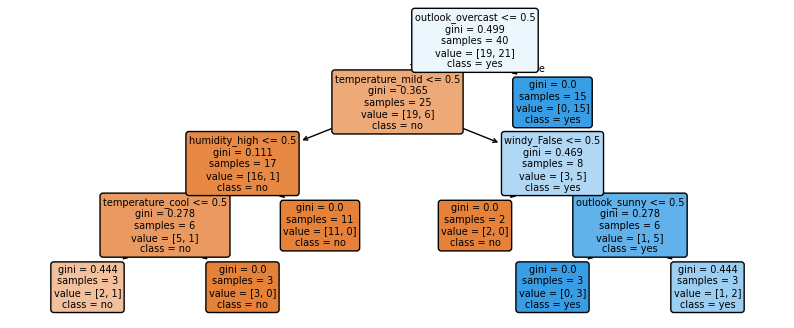

In [141]:
# 5. One‑Hot‑DT pipeline ----------------------------------------------------
from sklearn.preprocessing import OneHotEncoder

oh_dt = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # dense matrix
    ("tree", DecisionTreeClassifier(min_samples_leaf=2, random_state=0))
]).fit(train[X_cols], y_tr)


y_pred = oh_dt.predict(test[X_cols])
print("\nOneHot‑DT accuracy:", round(accuracy_score(y_te, y_pred),3),
      "  prec/rec/f1:", precision_recall_fscore_support(y_te, y_pred, zero_division=0)[0:3])

print(tree.export_text(oh_dt.named_steps["tree"],
                       feature_names=oh_dt.named_steps["ohe"].get_feature_names_out(X_cols)))

plt.figure(figsize=(10,4))
plot_tree(oh_dt.named_steps["tree"],
          feature_names=oh_dt.named_steps["ohe"].get_feature_names_out(X_cols),
          class_names=lab.classes_, filled=True, rounded=True, fontsize=7); plt.show()

if HAVE_DTV:
    dtreeviz.model(oh_dt.named_steps["tree"],
                   oh_dt.named_steps["ohe"].transform(train[X_cols]),
                   y_tr, feature_names=oh_dt.named_steps["ohe"].get_feature_names_out(X_cols),
                   target_name="play", class_names=list(lab.classes_)).view(scale=1.2)


|--- outlook_overcast <= 0.50
|   |--- temperature_mild <= 0.50
|   |   |--- humidity_high <= 0.50
|   |   |   |--- temperature_cool <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- temperature_cool >  0.50
|   |   |   |   |--- class: 0
|   |   |--- humidity_high >  0.50
|   |   |   |--- class: 0
|   |--- temperature_mild >  0.50
|   |   |--- windy_False <= 0.50
|   |   |   |--- class: 0
|   |   |--- windy_False >  0.50
|   |   |   |--- outlook_sunny <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- outlook_sunny >  0.50
|   |   |   |   |--- class: 1
|--- outlook_overcast >  0.50
|   |--- class: 1



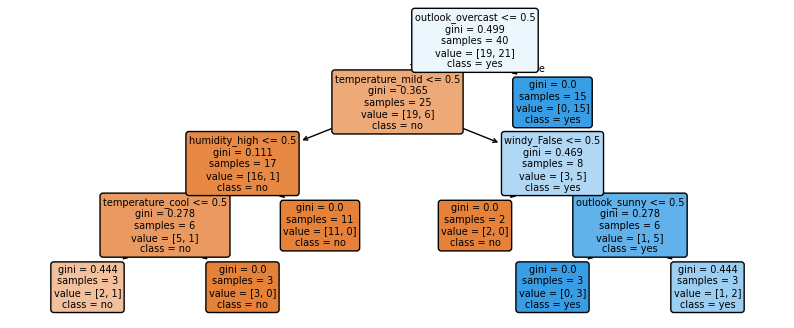

In [142]:
from sklearn import tree
# textual rule dump
print(
    tree.export_text(
        ohe_pipe.named_steps["tree"],                 # the fitted DecisionTree
        feature_names = ohe_pipe.named_steps["ohe"]   # the fitted encoder
                          .get_feature_names_out(X_cols)
    )
)

# matplotlib plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
tree.plot_tree(
    ohe_pipe.named_steps["tree"],
    feature_names = ohe_pipe.named_steps["ohe"]
                        .get_feature_names_out(X_cols),
    class_names = ["no","yes"],
    filled=True, rounded=True, fontsize=7
)
plt.show()


In [144]:
# 6. Random‑Forest (ordinal & one‑hot) --------------------------------------
rf_ord = RandomForestClassifier(n_estimators=200, random_state=0).fit(
            ord_dt.named_steps["enc"].transform(train[X_cols]), y_tr)
rf_oh  = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("rf",  RandomForestClassifier(n_estimators=200, random_state=0))
]).fit(train[X_cols], y_tr)

def score(name, model, X):
    yp = model.predict(X); acc = round(accuracy_score(y_te, yp),3)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, yp, average=None)
    print(f"{name:<8} acc={acc}  prec={pr} recall={rc}")

score("RF‑Ord", rf_ord, ord_dt.named_steps["enc"].transform(test[X_cols]))
score("RF‑OH",  rf_oh,  test[X_cols])

RF‑Ord   acc=1.0  prec=[1. 1.] recall=[1. 1.]
RF‑OH    acc=1.0  prec=[1. 1.] recall=[1. 1.]


In [145]:
# 7. Feature importance tables ---------------------------------------------
dt_imp = pd.Series(oh_dt.named_steps["tree"].feature_importances_,
                   index=oh_dt.named_steps["ohe"].get_feature_names_out(X_cols)).sort_values(ascending=False)
rf_imp = pd.Series(rf_oh.named_steps["rf"].feature_importances_,
                   index=rf_oh.named_steps["ohe"].get_feature_names_out(X_cols)).sort_values(ascending=False)
print("\nTop DT splits:\n", dt_imp.head(5).to_string())
print("\nTop RF splits:\n", rf_imp.head(5).to_string())


Top DT splits:
 outlook_overcast    0.626615
temperature_mild    0.201793
windy_False         0.120540
temperature_cool    0.019286
outlook_sunny       0.019286

Top RF splits:
 outlook_overcast    0.330540
outlook_rainy       0.149700
outlook_sunny       0.106665
temperature_mild    0.089658
windy_True          0.079387


In [146]:
# 8. Depth sweep ------------------------------------------------------------
print("\nmax_depth grid:")
for d in range(1,7):
    oh_dt.set_params(tree__max_depth=d).fit(train[X_cols], y_tr)
    print(f" depth={d}: {round(accuracy_score(y_te, oh_dt.predict(test[X_cols])),3)}")

print("\nDone")



max_depth grid:
 depth=1: 0.7
 depth=2: 0.8
 depth=3: 0.8
 depth=4: 0.8
 depth=5: 0.8
 depth=6: 0.8

Done
